<a href="https://colab.research.google.com/github/puckgroen/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [3]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel

In [4]:
# Data splitting

# Data loading
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y = data['label']
del data['label']

sss = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=None)
cv_4fold = model_selection.StratifiedKFold(n_splits=4)

count = 0 
for train_index, test_index in sss.split(data, y):
    train_scores = []
    test_scores = []
    count += 1
    #print(f'Iteration {count}')
    data_array = pd.DataFrame.from_dict(data) #Needed to be able to index this later 
    split_X_train = data_array.iloc[train_index]
    split_y_train = y[train_index]
    split_X_test = data_array.iloc[test_index]
    split_y_test = y[test_index]
    #print(f'Training dataset size {len(split_X_train)}')
    #print(f'Test dataset size {len(split_X_test)}')

    # Loop over the folds
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]
        #print(f'Validation size in current fold = {len(X_validation)}')
        

#print(X_train)

The number of samples: 113
The number of features: 159


The data has 159 features and 113 samples/subjects. The labels are given as either T12 (low) or T34 (high). 

The aim of this study is to predict the T-stage (high/low) in patients with H&N cancer based on features, extracted from CT. A good performance on this dataset would be above 70% mean accuracy.

Train data preprocessing

In [5]:
# 1. Scaling (standard, min max, robust)

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)


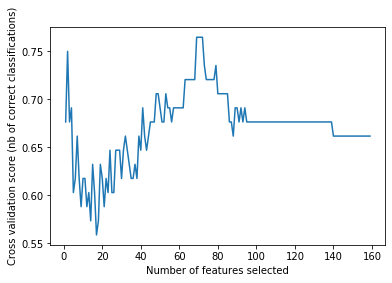

Optimal number of features : 69


In [6]:
# 2. Feature selection/extraction
# Create the Recursive Feature Elimination object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Optimal number of features : %d" % rfecv.n_features_)

In [7]:
# 3. PCA
n_selected_features = rfecv.n_features_
n_samples = len(X_train.index)
n_components = min(n_samples, n_selected_features)
pca = decomposition.PCA(n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# print(X_train_pca)
# X_train_pca.shape

In [8]:
# 4. Imputation missing data
missing_values=[0.0, 1.0]
for elem in missing_values:
    imputer = KNNImputer(missing_values=elem, n_neighbors=5, weights='uniform')
    X_train_imputed = imputer.fit_transform(X_train_pca)
# print(X_train_imputed)
# X_train_imputed.shape

In [10]:
# Create some classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
homemade_random_forest = BaggingClassifier(DecisionTreeClassifier())
voting_ensemble = VotingClassifier(
    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())],
    voting='soft')

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(), 
         LogisticRegression(),KNeighborsClassifier()]
clsfs_fit = list()
# SGDClassifier() staat er nu even niet tussen

# Fit the classifiers
for clf in clsfs:
    clf.fit(X_train_imputed, y_train)
    y_pred = clf.predict(X_train_imputed)
    clsfs_fit.append(clf)
    # Calculate metrics
    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X_train_imputed)[:, 1]
    else:
       y_score = y_pred

# The hasattr function checks whether an object, function or package has
# a certain attribute. This attribute can be a subfunction, or again an
# object or function, but also things like scalars or strings.
   
    auc=metrics.roc_auc_score(y_train, y_score)
    accuracy=metrics.accuracy_score(y_train, y_pred)
    F1=metrics.f1_score(y_train, y_pred, pos_label='T12')
    precision=metrics.precision_score(y_train, y_pred, pos_label='T12')
    recall=metrics.recall_score(y_train, y_pred, pos_label='T12')
# accuracy, AUC, f1score, precision, recall
    print(type(clf))
    print('Acc:' +str(accuracy))
    print('AUC:' +str(auc))
    print('F1:' +str(F1))
    print('precision:' +str(precision))
    print('recall:' +str(recall))

<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Acc:0.5735294117647058
AUC:0.5956709956709957
F1:0.5671641791044776
precision:0.59375
recall:0.5428571428571428
<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
Acc:1.0
AUC:1.0
F1:1.0
precision:1.0
recall:1.0
<class 'sklearn.naive_bayes.GaussianNB'>
Acc:0.8823529411764706
AUC:0.9567099567099568
F1:0.8787878787878788
precision:0.9354838709677419
recall:0.8285714285714286
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Acc:1.0
AUC:1.0
F1:1.0
precision:1.0
recall:1.0


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')